In [1]:
# Import required libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import pylab
from scipy import stats

sns.set()

In [2]:
# Load dataset
orders = pd.read_csv('orders.csv').drop(['Unnamed: 0'],axis=1)
orders.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,CancelledOrder,InternationalOrders,TotalPrice
0,536365,85123A,6,2010-12-01 08:26:00,2.55,C17850,United Kingdom,CREAM HANGING HEART T-LIGHT HOLDER,0,0,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,C17850,United Kingdom,WHITE METAL LANTERN,0,0,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,C17850,United Kingdom,CREAM CUPID HEARTS COAT HANGER,0,0,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,C17850,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,0,0,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,C17850,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,0,0,20.34


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404618 entries, 0 to 404617
Data columns (total 11 columns):
InvoiceNo              404618 non-null object
StockCode              404618 non-null object
Quantity               404618 non-null int64
InvoiceDate            404618 non-null object
UnitPrice              404618 non-null float64
CustomerID             404618 non-null object
Country                404618 non-null object
Description            404618 non-null object
CancelledOrder         404618 non-null int64
InternationalOrders    404618 non-null int64
TotalPrice             404618 non-null float64
dtypes: float64(2), int64(3), object(6)
memory usage: 34.0+ MB


In [4]:
# Convert InvoiceDate to datetime object
orders.InvoiceDate = pd.to_datetime(orders.InvoiceDate)

# Truncate the minutes part of datetime object
orders['InvoiceDate'] = orders.InvoiceDate.dt.date

In [5]:
# Confirm all cancelled orders have negative TotalPrice and Quantity

print(orders[(orders.InvoiceNo.str.startswith('C')) & (orders.TotalPrice>0)])
print(orders[(orders.InvoiceNo.str.startswith('C')) & (orders.Quantity>0)])

Empty DataFrame
Columns: [InvoiceNo, StockCode, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Description, CancelledOrder, InternationalOrders, TotalPrice]
Index: []
Empty DataFrame
Columns: [InvoiceNo, StockCode, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Description, CancelledOrder, InternationalOrders, TotalPrice]
Index: []


We will drop following columns:
1. InvoiceNo and CustomerID: As we have to predict itemwise sales, we don't need these columns 
1. Country, InternationalOrders: We are not making distinction between international or domestic sales in the predictions, so we don't need this column
1. Description: We have the StockCode, so this is repetitive
1. CancelledOrder: Cancelled orders have negative quantity and price. So while aggregating the dataset, cancellations will be taken into account. We don't need this column.
1. UnitPrice: In our dataset, same item has different prices. So we will keep TotalPrice and drop UnitPrice. While aggregating we will calculate the UnitPrice from TotalPrice and Quantity for each item and month again.

In [6]:
orders.drop(['InvoiceNo', 'CustomerID','Country','InternationalOrders','Description','CancelledOrder','UnitPrice'],
            axis=1,inplace=True)

### Feature Engineering

In [7]:
orders.head()

,StockCode,Quantity,InvoiceDate,TotalPrice
0,85123A,6,2010-12-01,15.30
1,71053,6,2010-12-01,20.34
2,84406B,8,2010-12-01,22.00
3,84029G,6,2010-12-01,20.34
4,84029E,6,2010-12-01,20.34


In [8]:
# holidays = ['2010-12-27', '2010-12-28', '2011-01-03', '2011-04-22', '2011-04-25', '2011-04-29', '2011-05-02',
#             '2011-05-30', '2011-08-29']
# temp = pd.DataFrame({'InvoiceDate':holidays})
# temp['StockCode'] = 0
# temp['Quantity'] = 0
# temp['TotalPrice'] = 0
# orders.append(temp,ignore_index=True,sort=False)

In [9]:
orders = orders.groupby(['InvoiceDate','StockCode'],as_index=False).sum()
orders.InvoiceDate = pd.to_datetime(orders.InvoiceDate)

In [10]:
orders['Year'] = orders.InvoiceDate.dt.year
orders['Quarter'] = orders.InvoiceDate.dt.quarter
orders['Month'] = orders.InvoiceDate.dt.month
orders['Week'] = orders.InvoiceDate.dt.week
orders['Weekday'] = orders.InvoiceDate.dt.weekday
orders['Day'] = orders.InvoiceDate.dt.day
orders['Dayofyear'] = orders.InvoiceDate.dt.dayofyear
orders['UnitPrice'] = orders.TotalPrice/orders.Quantity

In [11]:
orders.head()

,InvoiceDate,StockCode,Quantity,TotalPrice,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,UnitPrice
0,2010-12-01,10002,60,51.00,2010,4,12,48,2,1,335,0.85
1,2010-12-01,10125,2,1.70,2010,4,12,48,2,1,335,0.85
2,2010-12-01,10133,5,4.25,2010,4,12,48,2,1,335,0.85
3,2010-12-01,15044B,1,2.95,2010,4,12,48,2,1,335,2.95
4,2010-12-01,15056BL,20,113.00,2010,4,12,48,2,1,335,5.65


In [12]:
orders.describe()

,Quantity,TotalPrice,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,UnitPrice
count,224628.000000,224628.000000,224628.000000,224628.000000,224628.000000,224628.000000,224628.000000,224628.000000,224628.000000,2.240890e+05
mean,21.755712,36.874346,2010.936713,2.739730,7.253993,29.413662,2.617821,15.114460,204.576740,NaN
std,65.986694,136.945165,0.243479,1.130302,3.448225,14.901138,1.931312,8.647994,104.412414,NaN
min,-8974.000000,-3825.360000,2010.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000,-inf
25%,3.000000,6.250000,2011.000000,2.000000,4.000000,16.000000,1.000000,7.000000,111.000000,8.500000e-01
50%,8.000000,15.300000,2011.000000,3.000000,8.000000,32.000000,2.000000,15.000000,220.000000,1.663433e+00
75%,24.000000,33.000000,2011.000000,4.000000,10.000000,43.000000,4.000000,22.000000,299.000000,3.750000e+00
max,4848.000000,39619.500000,2011.000000,4.000000,12.000000,51.000000,6.000000,31.000000,357.000000,inf


In [13]:
# Drop rows with negative Quantity

orders = orders.drop(orders[orders.Quantity<=0].index).reset_index(drop=True)
orders = orders.drop(orders[orders.TotalPrice<=0].index).reset_index(drop=True)

# Removing outliers in Quantity and TotalPrice
orders = orders[(np.abs(stats.zscore(orders.Quantity)) < 3)]
orders = orders[(np.abs(stats.zscore(orders.TotalPrice)) < 3)]

In [14]:
orders.describe()

,Quantity,TotalPrice,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,UnitPrice
count,216753.000000,216753.000000,216753.000000,216753.000000,216753.000000,216753.000000,216753.000000,216753.000000,216753.000000,216753.000000
mean,17.320586,29.372231,2010.937057,2.738772,7.251461,29.402726,2.630510,15.127034,204.512533,2.885342
std,25.659530,42.252063,0.242860,1.130421,3.447829,14.900267,1.942232,8.651776,104.410938,4.465393
min,1.000000,0.060000,2010.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000,0.040000
25%,3.000000,6.640000,2011.000000,2.000000,4.000000,16.000000,1.000000,7.000000,111.000000,0.850000
50%,8.000000,15.300000,2011.000000,3.000000,8.000000,32.000000,2.000000,15.000000,220.000000,1.650000
75%,23.000000,31.600000,2011.000000,4.000000,10.000000,43.000000,4.000000,22.000000,299.000000,3.750000
max,211.000000,343.050000,2011.000000,4.000000,12.000000,51.000000,6.000000,31.000000,357.000000,295.000000


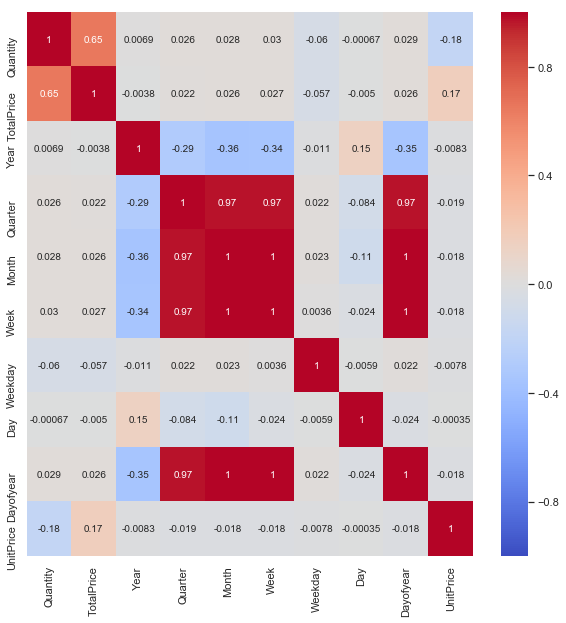

In [15]:
# Get correlations of each features in dataset
corrmat = orders.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
# Plot heat map
g=sns.heatmap(orders[top_corr_features].corr(),annot=True,cmap="coolwarm",vmin=-1,vmax=1,center=0)

Above heatmap shows strong correlation between Quarter, Month, Dayofyear and Week. We will drop , Dayofyear, quarter and month, and just keep week, as week is most strongly correlated with week. Year has strong correlation with Day, and as it is not strongly correlated with Quantity, we will drop it.

In [16]:
orders.drop(['Month', 'Quarter','Dayofyear','Year'], axis=1,inplace=True)

In [17]:
orders.head()

,InvoiceDate,StockCode,Quantity,TotalPrice,Week,Weekday,Day,UnitPrice
0,2010-12-01,10002,60,51.00,48,2,1,0.85
1,2010-12-01,10125,2,1.70,48,2,1,0.85
2,2010-12-01,10133,5,4.25,48,2,1,0.85
3,2010-12-01,15044B,1,2.95,48,2,1,2.95
4,2010-12-01,15056BL,20,113.00,48,2,1,5.65


In [19]:
orders.to_csv('data.csv')